Registering model balance-predictor
✅ Model registered: balance-predictor

Sample Actual vs Predicted:
Actual: -2440.03 | Predicted: -1668.27
Actual: -1050.59 | Predicted: -17.14
Actual: -1919.81 | Predicted: 1094.93
Actual: -3716.96 | Predicted: -29.32
Actual: -1732.34 | Predicted: -767.68

MAE: 5786.67, RMSE: 6951.20, R²: -2.55


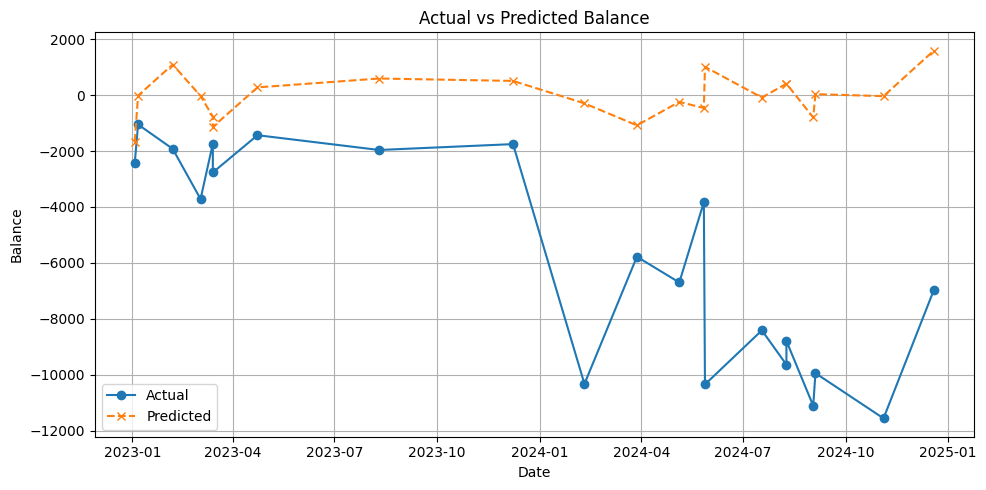

In [ ]:
# train_predict.ipynb (final cleaned version)

# 🔹 1. Install Packages
!pip install pandas scikit-learn azure-storage-blob matplotlib --quiet

# 🔹 2. Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
import json, os, joblib
from azureml.core import Workspace, Model

# 🔹 3. Load JSONs from Azure Blob Storage
connection_string = "test"
container_name = "journaldata"
balance_blob = "balance_records.json"
journal_blob = "journal_entries.json"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
balance_records = json.loads(blob_service_client.get_blob_client(container=container_name, blob=balance_blob).download_blob().readall().decode('utf-8'))
journal_entries = json.loads(blob_service_client.get_blob_client(container=container_name, blob=journal_blob).download_blob().readall().decode('utf-8'))

df = pd.DataFrame(balance_records)
journal_df = pd.DataFrame(journal_entries)

# 🔹 4. Preprocess Balance Records
df['DATE'] = pd.to_datetime(df['DATE'])
df['BALANCE'] = pd.to_numeric(df['BALANCE'], errors='coerce')
df.dropna(subset=['BALANCE'], inplace=True)
df.sort_values('DATE', inplace=True)
df['YEAR'] = df['DATE'].dt.year

# 🔹 5. Preprocess Journal Entries and Aggregate
journal_df['ENTRY_DATE'] = pd.to_datetime(journal_df['ENTRY_DATE'])

journal_agg = journal_df.groupby([journal_df['ENTRY_DATE'].dt.date, 'SAP_BOOK_ID']).agg(
    JOURNAL_TOTAL_AMOUNT=('VALUE', 'sum'),
    JOURNAL_AVG_AMOUNT=('VALUE', 'mean'),
    JOURNAL_COUNT=('VALUE', 'count')
).reset_index()

journal_agg['DATE'] = pd.to_datetime(journal_agg['ENTRY_DATE'])
journal_agg.drop(columns=['ENTRY_DATE'], inplace=True)

# 🔹 6. Merge and Prepare Dataset
merged_df = pd.merge(df, journal_agg, how='left', on=['DATE', 'SAP_BOOK_ID'])
merged_df['DATE_ORDINAL'] = merged_df['DATE'].map(datetime.toordinal)
merged_df.dropna(subset=['BALANCE', 'JOURNAL_COUNT', 'JOURNAL_TOTAL_AMOUNT', 'JOURNAL_AVG_AMOUNT'], inplace=True)

# 🔹 7. Train/Test Split
train_df = merged_df[merged_df['YEAR'] <= 2022]
test_df = merged_df[merged_df['YEAR'] > 2022]
feature_cols = ['DATE_ORDINAL', 'JOURNAL_COUNT', 'JOURNAL_TOTAL_AMOUNT', 'JOURNAL_AVG_AMOUNT']
X_train, y_train = train_df[feature_cols], train_df['BALANCE']
X_test, y_test = test_df[feature_cols], test_df['BALANCE']

# 🔹 8. Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# 🔹 9. Save Model
model_filename = "balance_model.pkl"
joblib.dump(model, model_filename)

# 🔹 10. Register in Azure ML
ws = Workspace.from_config(path="config.json")
model_registered = Model.register(
    workspace=ws,
    model_path=model_filename,
    model_name="balance-predictor",
    description="Linear regression model for predicting balance"
)

print("✅ Model registered:", model_registered.name)

# 🔹 11. Evaluate
y_pred = model.predict(X_test)
print("\nSample Actual vs Predicted:")
for a, p in zip(y_test[:5], y_pred[:5]):
    print(f"Actual: {a:.2f} | Predicted: {p:.2f}")

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# 🔹 12. Plot
plt.figure(figsize=(10,5))
plt.plot(test_df['DATE'], y_test, label="Actual", marker='o')
plt.plot(test_df['DATE'], y_pred, label="Predicted", linestyle='--', marker='x')
plt.title("Actual vs Predicted Balance")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
